In [16]:
import os
from dotenv import load_dotenv, find_dotenv

try:
    envPath = find_dotenv()

    if not envPath:
        raise ModuleNotFoundError(".env FILE NOT FOUND")
    if not load_dotenv(envPath):
        raise EnvironmentError("FAILED TO LOAD .env")
    
    openai_api_key = os.environ.get("OPENAI_API_KEY")
    openai_model = os.environ.get("OPENAI_MODEL")

    if not openai_api_key:
        raise ValueError("API NOT FOUND")
    if not openai_model:
        raise ValueError("MODEL NOT FOUND")
except Exception as e:
    print(f"ERROR: {e}")
    openai_api_key, openai_model = None, None

In [2]:
from typing import Annotated, TypedDict, Sequence
import operator, json
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = openai_model, api_key = openai_api_key)

In [7]:
llm.invoke("Hi there").content

'Hello! How can I assist you today?'

In [18]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiplication Tool"""
    return a * b

@tool
def search(query: str):
    """Search Tool"""
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    return result

search('Who is the president of USA?')

[{'title': 'President of the United States - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/President_of_the_United_States',
  'content': '*   [Minority Leader](https://en.wikipedia.org/wiki/Party_leaders_of_the_United_States_Senate "Party leaders of the United States Senate")[Chuck Schumer](https://en.wikipedia.org/wiki/Chuck_Schumer "Chuck Schumer") (D)\n[Executive](https://en.wikipedia.org/wiki/Executive_branch_of_the_United_States "Executive branch of the United States")\n\n*   **President of the United States**\n\n*   [Donald Trump](https://en.wikipedia.org/wiki/Donald_Trump "Donald Trump") (R) [...] resignation").[[C]](https://en.wikipedia.org/wiki/President_of_the_United_States#cite_note-22) In all, [45 individuals](https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States "List of presidents of the United States") have served 47 presidencies spanning 60 four-year terms.[[D]](https://en.wikipedia.org/wiki/President_of_the_United_States#cite_note-24)[Donald Trump

In [20]:
tools = [search, multiply]

llmWithTools = llm.bind_tools(tools)

In [ ]:
class AgentState:
    messages: Annotated[Sequence[BaseMessage], operator.add]

def invokeModel(state: AgentState):
    messages = state['messages']
    question = messages[-1]
    return {'messages': [llmWithTools.invoke(question)]}

In [22]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])

    if len(tool_calls):
        return "tool"
    return "end"

In [26]:
graph = StateGraph(AgentState)

graph.add_node("ai_assistant", invokeModel)
graph.add_node("tool", invokeModel)

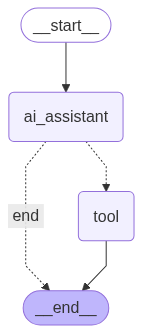

In [27]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool", "end": END})
graph.add_edge("tool", END)

graph.set_entry_point("ai_assistant")

app = graph.compile()
app